<a href="https://colab.research.google.com/github/chornamarta/ml3.0/blob/main/Module%202/EnsembleMethods.Cross-validation/HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
raw_df = pd.read_csv('train.csv',index_col=0)

In [3]:
train_df, val_df = split_train_val(raw_df,'Exited')

In [4]:
list_input_cols = [x for x in raw_df.columns if x != 'Exited']

In [5]:
train_inputs, train_targets = separate_inputs_targets(train_df,list_input_cols,'Exited')
val_inputs, val_targets = separate_inputs_targets(val_df,list_input_cols,'Exited')

In [6]:
train_inputs.shape

(12000, 12)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [6]:
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [7]:
train_inputs[categorical_cols] = train_inputs[categorical_cols].astype('category')
val_inputs[categorical_cols] = val_inputs[categorical_cols].astype('category')

In [9]:
val_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 6490 to 3024
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CustomerId       3000 non-null   float64 
 1   Surname          3000 non-null   category
 2   CreditScore      3000 non-null   float64 
 3   Geography        3000 non-null   category
 4   Gender           3000 non-null   category
 5   Age              3000 non-null   float64 
 6   Tenure           3000 non-null   float64 
 7   Balance          3000 non-null   float64 
 8   NumOfProducts    3000 non-null   float64 
 9   HasCrCard        3000 non-null   float64 
 10  IsActiveMember   3000 non-null   float64 
 11  EstimatedSalary  3000 non-null   float64 
dtypes: category(3), float64(9)
memory usage: 266.6 KB


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [8]:
from sklearn.metrics import roc_auc_score
def roc(inputs,targets,model,name):
  roc_auc = roc_auc_score(targets, model.predict_proba(inputs)[:, 1])
  print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")

In [9]:
from xgboost import XGBClassifier

In [10]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda'
)

In [11]:
xgb_clf.fit(train_inputs, train_targets)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...)

In [12]:
roc(train_inputs,train_targets,xgb_clf,'Training')
roc(val_inputs,val_targets,xgb_clf,'Validating')

Area under ROC score on Training dataset: 0.95%
Area under ROC score on Validating dataset: 0.93%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [19:40:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


  
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance? - *виглядає дуже і дуже навіть добре, трошки нижчий відсоток на валідаційних. але не критичний*
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість? - *так, тут модель краща*

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [13]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [14]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        eval_metric='auc',
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)

    pred_prob = clf.predict_proba(val_inputs)
    auroc = roc_auc_score(val_targets, pred_prob[:,1])

    return {'loss': -auroc, 'status': STATUS_OK}

In [15]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [16]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 10%|█         | 2/20 [00:00<00:06,  2.60trial/s, best loss: -0.9324322655874889]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 15%|█▌        | 3/20 [00:01<00:06,  2.56trial/s, best loss: -0.9325920845051101]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 25%|██▌       | 5/20 [00:01<00:04,  3.14trial/s, best loss: -0.9354561355374169]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 30%|███       | 6/20 [00:02<00:03,  3.62trial/s, best loss: -0.9354561355374169]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 40%|████      | 8/20 [00:02<00:02,  4.20trial/s, best loss: -0.9354561355374169]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 45%|████▌     | 9/20 [00:02<00:03,  3.60trial/s, best loss: -0.9354561355374169]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 55%|█████▌    | 11/20 [00:03<00:02,  3.69trial/s, best loss: -0.9354561355374169]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 60%|██████    | 12/20 [00:03<00:01,  4.34trial/s, best loss: -0.9364267096508676]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 65%|██████▌   | 13/20 [00:03<00:01,  4.25trial/s, best loss: -0.9364267096508676]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 75%|███████▌  | 15/20 [00:04<00:01,  4.42trial/s, best loss: -0.9364267096508676]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 80%|████████  | 16/20 [00:04<00:00,  4.66trial/s, best loss: -0.9365553192948761]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 90%|█████████ | 18/20 [00:04<00:00,  4.22trial/s, best loss: -0.9370351190067906]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 95%|█████████▌| 19/20 [00:05<00:00,  4.30trial/s, best loss: -0.9370351190067906]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [19:41:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



100%|██████████| 20/20 [00:05<00:00,  3.54trial/s, best loss: -0.9370351190067906]


In [17]:
print("Найкращі гіперпараметри: ", best)

Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.836283867773219), 'gamma': np.float64(0.03849338098415456), 'learning_rate': np.float64(0.17473075323286205), 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 450, 'reg_alpha': np.float64(0.16015100519338354), 'reg_lambda': np.float64(0.08009471003982183), 'subsample': np.float64(0.7795724239506392)}


In [18]:
final_clf_xgb = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    eval_metric='auc',
    device='cuda',
)

final_clf_xgb.fit(train_inputs, train_targets)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.836283867773219), device='cuda',
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=np.float64(0.03849338098415456), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.17473075323286205), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, ...)

In [21]:
roc(val_inputs,val_targets,final_clf_xgb,'Validating')
roc(train_inputs,train_targets,final_clf_xgb,'Training')

Area under ROC score on Validating dataset: 0.93%
Area under ROC score on Training dataset: 0.95%


*здається модель натрнеувалась краще , але валідаційних даних не стала краще*

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [21]:
pip install lightgbm

*я каюсь, пробувала з gpu, але успішно гугл колаб заблокав цю можливість після пробного запуску*

In [20]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [21]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in categorical_cols]

In [22]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,
    #missing=np.nan, давало помилку
)

lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain,

LGBMClassifier(cat_feature=[1, 3, 4], max_depth=3, n_estimators=50)

In [23]:
roc(train_inputs,train_targets,lgb_clf,'Training')
roc(val_inputs,val_targets,lgb_clf,'Validating')


Area under ROC score on Training dataset: 0.95%
Area under ROC score on Validating dataset: 0.94%


*модель вийшло покращити якщо порівнюввти з XGBoost, і також має хороший відсоток як на ренувальних так і на валідаційних*

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [24]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'],
        categorical_feature=cat_feature_indexes,
        eval_metric='auc',
        )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)])

    pred_prob = clf.predict_proba(val_inputs)
    auroc = roc_auc_score(val_targets, pred_prob[:,1])

    return {'loss': -auroc, 'status': STATUS_OK}

In [35]:
?lgb

In [25]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

In [26]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] categorical_feature is set=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] categorical_feature is set=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> inits

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [27]:
print("Найкращі гіперпараметри: ", best)

Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.8850243670042589), 'learning_rate': np.float64(0.07457965427848644), 'max_depth': 5, 'min_child_weight': 5, 'min_split_gain': np.float64(0.08513765695104956), 'n_estimators': 100, 'num_leaves': 85, 'reg_alpha': np.float64(0.9947678762602153), 'reg_lambda': np.float64(0.004408015938028198), 'subsample': np.float64(0.7792173644866405)}


In [28]:
final_clf_lgb = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
)

final_clf_lgb.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain,

LGBMClassifier(cat_feature=[1, 3, 4],
               colsample_bytree=np.float64(0.8850243670042589),
               learning_rate=np.float64(0.07457965427848644), max_depth=5,
               min_child_weight=5,
               min_split_gain=np.float64(0.08513765695104956), num_leaves=85,
               reg_alpha=np.float64(0.9947678762602153),
               reg_lambda=np.float64(0.004408015938028198),
               subsample=np.float64(0.7792173644866405))

In [29]:
roc(train_inputs,train_targets,final_clf_lgb,'Training')
roc(val_inputs,val_targets,final_clf_lgb,'Validating')

Area under ROC score on Training dataset: 0.97%
Area under ROC score on Validating dataset: 0.94%


*спрацювала добре, на тренувальних краще нід рандомний вибір параметрів, на валідаційних так само*

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [31]:
test_raw_df = pd.read_csv('test.csv',index_col=0)
sample_df = pd.read_csv('sample_submission.csv')

In [32]:
test_raw_df[categorical_cols] = test_raw_df[categorical_cols].astype('category')

In [33]:
test_preds = final_clf_lgb.predict_proba(test_raw_df)[:, 1]
sample_df.Exited = test_preds
sample_df.to_csv('submission_log_reg_lgb2.csv',index=False)

In [49]:
test_preds2 = final_clf_xgb.predict_proba(test_raw_df)[:, 1]
sample_df.Exited = test_preds2
sample_df.to_csv('submission_log_reg_xgb.csv',index=False)

найкраще себе з резултатів показав XGBoost в kaggle)
 спробувала два завантажити, бо сумнівалась у LightGBM і не дарма

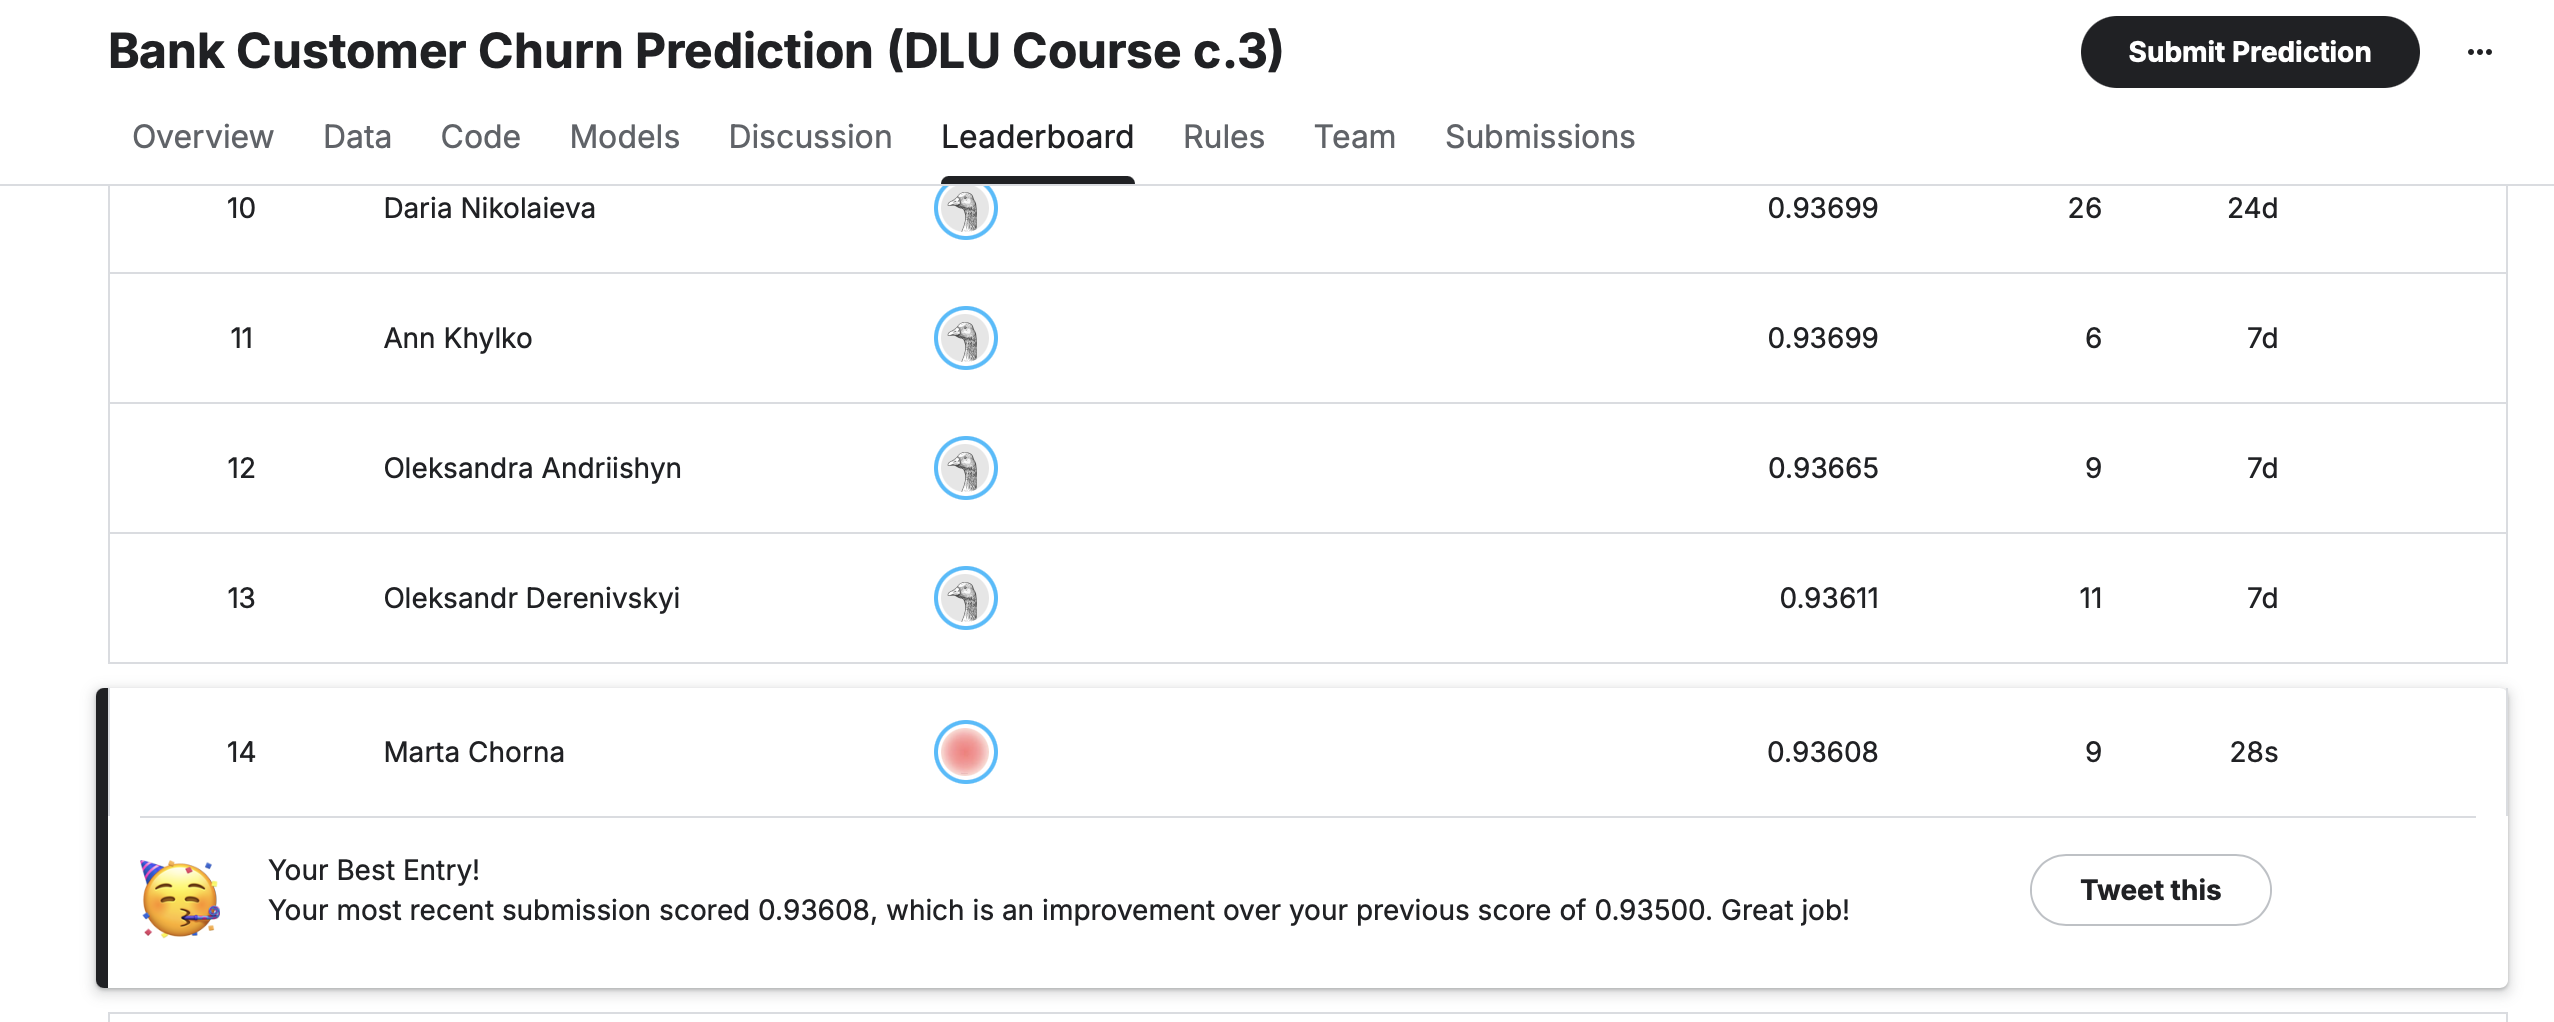